In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()

from vega_datasets import data

import warnings
warnings.filterwarnings("ignore")

In [28]:
stocks = data.stocks()

In [29]:
stocks

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45
...,...,...,...
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62


In [30]:
# to transform such that each symbol is it's own column and each row is one month
stocks = stocks.pivot_table('price', 'date', 'symbol')

In [46]:
stocks

symbol,AAPL,AMZN,GOOG,IBM,MSFT
ds,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45
...,...,...,...,...,...
2009-11-01,199.91,135.91,583.00,125.79,29.27
2009-12-01,210.73,134.52,619.98,130.32,30.34
2010-01-01,192.06,125.41,529.94,121.85,28.05


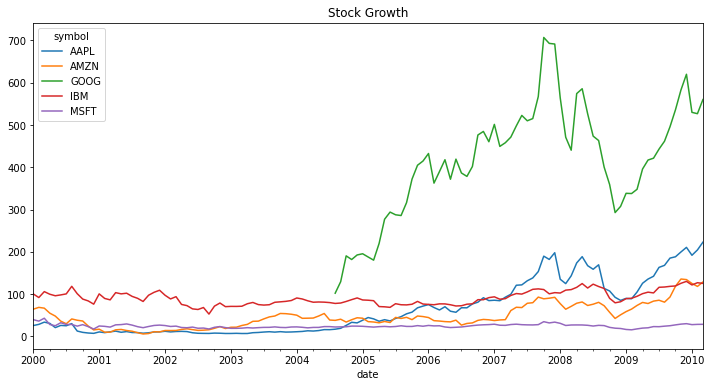

In [31]:
stocks.plot(figsize=(12,6))
plt.title('Stock Growth')
plt.show()

In [48]:
ibm = stocks.iloc[:,3:4]

In [49]:
ibm.index.rename('ds', inplace = True)

ibm.columns.rename('', inplace = True)

ibm.rename(columns = {'IBM': 'y'}, inplace = True)

In [51]:
ibm

,y
ds,
2000-01-01,100.52
2000-02-01,92.11
2000-03-01,106.11
2000-04-01,99.95
2000-05-01,96.31
...,...
2009-11-01,125.79
2009-12-01,130.32
2010-01-01,121.85


### Splitting into Train, Validate and Test

In [52]:
train = ibm[:'2007']

In [53]:
validate = ibm['2008']

In [54]:
test = ibm['2009':]

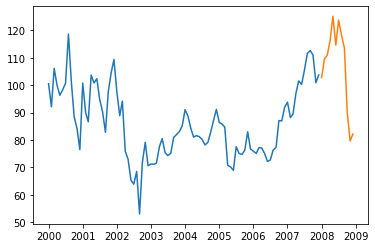

In [56]:
plt.plot(train)
plt.plot(validate)
plt.show()

In [59]:
train['cap'] = 200
train['floor'] = 20

# reset index as prophet needs ds to be a column and not an index. 
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

train.head(2)

,index,ds,y,cap,floor
0,0,2000-01-01,100.52,200,20
1,1,2000-02-01,92.11,200,20


In [60]:
m = Prophet(daily_seasonality = False,
            weekly_seasonality = True,
            growth = 'logistic',
            changepoint_range = 0.9)
m.add_country_holidays(country_name='US')
m.fit(train)

print(m.train_holiday_names)

0                  New Year's Day
1       New Year's Day (Observed)
2      Martin Luther King Jr. Day
3           Washington's Birthday
4                    Memorial Day
5                Independence Day
6                       Labor Day
7                    Columbus Day
8                    Veterans Day
9         Veterans Day (Observed)
10                   Thanksgiving
11                  Christmas Day
12    Independence Day (Observed)
13       Christmas Day (Observed)
dtype: object


In [61]:
future = m.make_future_dataframe(periods = len(validate))
future['cap'] = 200
future['floor'] = 20

In [62]:
pd.concat([future.head(2), future.tail(2)])

,ds,cap,floor
0,2000-01-01,200,20
1,2000-02-01,200,20
106,2007-12-12,200,20
107,2007-12-13,200,20


In [63]:
forecast = m.predict(future)

In [64]:
forecast.columns

Index(['ds', 'trend', 'cap', 'floor', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Christmas Day (Observed)',
       'Christmas Day (Observed)_lower', 'Christmas Day (Observed)_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Independence Day (Observed)', 'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
 

In [65]:
# select the dates for the holidays listed, and extract the sales predictions during those holidays
forecast[(forecast['Christmas Day'] + 
          forecast['Thanksgiving'] + 
          forecast["New Year's Day"]).abs() > 0]\
        [['ds', 
          'Christmas Day', 
          'Thanksgiving', 
          "New Year's Day"]][-10:]

,ds,Christmas Day,Thanksgiving,New Year's Day
0,2000-01-01,0.0,0.0,782.656745
12,2001-01-01,0.0,0.0,782.656745
24,2002-01-01,0.0,0.0,782.656745
36,2003-01-01,0.0,0.0,782.656745
48,2004-01-01,0.0,0.0,782.656745
60,2005-01-01,0.0,0.0,782.656745
72,2006-01-01,0.0,0.0,782.656745
84,2007-01-01,0.0,0.0,782.656745


In [22]:
apple = stocks.iloc[:,:1]

amazon = stocks.iloc[:, 1:2]

google = stocks.iloc[:,2:3]

ibm = stocks.iloc[:,3:4]

microsoft = stocks.iloc[:,4:5]